# Transaction Date Conversion and Min-Max Normalization

> **Pipeline Position:** Run this FIRST (independent variable, requires preprocessing)  
> **Input:** `handle_missing_data/output_data/4_discount_applied/final_cleaned_dataset.csv`  
> **Output:** `handle_rescale_data/output_data/transaction_date/data_rescaling_norm_transaction_date.csv`

---

## Overview

**Transaction Date** is currently stored as a string (YYYY-MM-DD format). Before it can be used in machine learning models, it must be:
1. **Converted to numeric format** (Unix timestamp in seconds)
2. **Rescaled using Min-Max Normalization** to [0, 1] range

---

## Why Min-Max Normalization for Transaction Date?

| Method | Suitability | Reason |
|--------|-------------|--------|
| **Min-Max Normalization** | ✅ **BEST** | Dates have clear bounds (min/max in dataset); no outliers; interpretable [0,1] scale |
| **Standardization** | ⚠️ Moderate | Large magnitude timestamps make mean/std less interpretable |
| **Robust Scaling** | ❌ Poor | Unnecessary (no outliers in temporal data) |

**Selected Method:** 🏆 **Min-Max Normalization**

**Interpretation:**
- **0** = Earliest transaction in dataset
- **1** = Most recent transaction in dataset
- **0.5** = Midpoint of data collection period

---

## Conversion Strategy

**Option 1: Unix Timestamp (Selected)** ✅
- Seconds since epoch (1970-01-01 00:00:00 UTC)
- Formula: `pd.to_datetime(df['Transaction Date']).astype(np.int64) // 10**9`
- **Pros:** Standard ML approach; reversible; preserves chronological order
- **Cons:** Large values (~1.6-1.7 billion), but normalized afterward

**Option 2: Ordinal Days** (Not Selected)
- Days since epoch
- **Cons:** Still large values (~700,000+)

**Option 3: Feature Engineering** (Not Selected)
- Extract Year, Month, Day, DayOfWeek, etc.
- **Cons:** Creates multiple columns; changes dataset structure

---

## Implementation Steps

1. Load cleaned dataset
2. Convert `Transaction Date` (string) → Unix timestamp (int64, seconds)
3. Apply Min-Max Normalization: `(X - min) / (max - min)`
4. Validate: Check range [0, 1], no NaN, chronological order preserved
5. Save output with original + numeric + scaled columns

In [1]:
# === Setup: Import libraries ===
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# File paths
INPUT_CSV = Path("../../../handle_missing_data/output_data/4_discount_applied/final_cleaned_dataset.csv")
OUTPUT_CSV = Path("../../output_data/transaction_date/data_rescaling_norm_transaction_date.csv")

# Column names
DATE_COL = "Transaction Date"
DATE_NUMERIC_COL = "Transaction Date Numeric"
DATE_SCALED_COL = "Transaction Date Scaled"

print("Setup complete.")

Setup complete.


## Step 1: Load Dataset

Load the cleaned dataset from the missing data handling pipeline.

In [2]:
# Load dataset
df = pd.read_csv(INPUT_CSV)

# Display basic info
print(f"Dataset loaded: {len(df)} rows, {len(df.columns)} columns")
print(f"\nFirst 5 rows of '{DATE_COL}' column:")
print(df[DATE_COL].head())
print(f"\nData type: {df[DATE_COL].dtype}")
print(f"Missing values: {df[DATE_COL].isna().sum()}")

Dataset loaded: 11971 rows, 11 columns

First 5 rows of 'Transaction Date' column:
0    2024-10-08
1    2022-03-12
2    2022-04-22
3    2023-11-09
4    2022-03-02
Name: Transaction Date, dtype: object

Data type: object
Missing values: 0


## Step 2: Convert to Unix Timestamp

Convert string dates (YYYY-MM-DD) to Unix timestamp (seconds since 1970-01-01).

In [3]:
# Convert to datetime, then to Unix timestamp (seconds)
df[DATE_NUMERIC_COL] = pd.to_datetime(df[DATE_COL]).astype(np.int64) // 10**9

# Display conversion results
print(f"Conversion complete!")
print(f"\nOriginal vs Numeric:")
print(df[[DATE_COL, DATE_NUMERIC_COL]].head(10))
print(f"\nNumeric column statistics:")
print(df[DATE_NUMERIC_COL].describe())
print(f"\nDate range:")
print(f"  Earliest: {pd.to_datetime(df[DATE_NUMERIC_COL].min(), unit='s').date()} ({df[DATE_NUMERIC_COL].min()})")
print(f"  Latest:   {pd.to_datetime(df[DATE_NUMERIC_COL].max(), unit='s').date()} ({df[DATE_NUMERIC_COL].max()})")
print(f"  Span:     {(df[DATE_NUMERIC_COL].max() - df[DATE_NUMERIC_COL].min()) / (365.25 * 24 * 3600):.2f} years")

Conversion complete!

Original vs Numeric:
  Transaction Date  Transaction Date Numeric
0       2024-10-08                1728345600
1       2022-03-12                1647043200
2       2022-04-22                1650585600
3       2023-11-09                1699488000
4       2022-03-02                1646179200
5       2023-09-25                1695600000
6       2022-11-26                1669420800
7       2023-10-17                1697500800
8       2024-11-05                1730764800
9       2023-08-03                1691020800

Numeric column statistics:
count    1.197100e+04
mean     1.689215e+09
std      2.813359e+07
min      1.640995e+09
25%      1.664410e+09
50%      1.689206e+09
75%      1.713917e+09
max      1.737158e+09
Name: Transaction Date Numeric, dtype: float64

Date range:
  Earliest: 2022-01-01 (1640995200)
  Latest:   2025-01-18 (1737158400)
  Span:     3.05 years


## Step 3: Apply Min-Max Normalization

Normalize Unix timestamps to [0, 1] range using Min-Max formula:

$$\text{Normalized} = \frac{X - X_{min}}{X_{max} - X_{min}}$$

Where:
- **0** = Earliest transaction
- **1** = Latest transaction

In [4]:
# Apply Min-Max Normalization
min_date = df[DATE_NUMERIC_COL].min()
max_date = df[DATE_NUMERIC_COL].max()

df[DATE_SCALED_COL] = (df[DATE_NUMERIC_COL] - min_date) / (max_date - min_date)

# Display results
print(f"Min-Max Normalization applied!")
print(f"\nNormalization parameters:")
print(f"  Min: {min_date} ({pd.to_datetime(min_date, unit='s').date()})")
print(f"  Max: {max_date} ({pd.to_datetime(max_date, unit='s').date()})")
print(f"  Range: {max_date - min_date} seconds")
print(f"\nScaled column statistics:")
print(df[DATE_SCALED_COL].describe())
print(f"\nSample of all three columns:")
print(df[[DATE_COL, DATE_NUMERIC_COL, DATE_SCALED_COL]].head(10))

Min-Max Normalization applied!

Normalization parameters:
  Min: 1640995200 (2022-01-01)
  Max: 1737158400 (2025-01-18)
  Range: 96163200 seconds

Scaled column statistics:
count    11971.000000
mean         0.501439
std          0.292561
min          0.000000
25%          0.243486
50%          0.501348
75%          0.758311
max          1.000000
Name: Transaction Date Scaled, dtype: float64

Sample of all three columns:
  Transaction Date  Transaction Date Numeric  Transaction Date Scaled
0       2024-10-08                1728345600                 0.908356
1       2022-03-12                1647043200                 0.062893
2       2022-04-22                1650585600                 0.099730
3       2023-11-09                1699488000                 0.608266
4       2022-03-02                1646179200                 0.053908
5       2023-09-25                1695600000                 0.567835
6       2022-11-26                1669420800                 0.295597
7       2023-10

## Step 4: Validation

Verify the scaled data meets all requirements.

In [5]:
# Validation checks
print("=" * 60)
print("VALIDATION CHECKS")
print("=" * 60)

# 1. Range check: all values in [0, 1]
range_check = (df[DATE_SCALED_COL].min() >= 0) and (df[DATE_SCALED_COL].max() <= 1)
print(f"✓ 1. All values in [0, 1]: {range_check}")
print(f"     Min: {df[DATE_SCALED_COL].min():.10f}")
print(f"     Max: {df[DATE_SCALED_COL].max():.10f}")

# 2. No missing values
no_missing = df[DATE_SCALED_COL].isna().sum() == 0
print(f"\n✓ 2. No missing values: {no_missing}")
print(f"     NaN count: {df[DATE_SCALED_COL].isna().sum()}")

# 3. No infinite values
no_inf = np.isfinite(df[DATE_SCALED_COL]).all()
print(f"\n✓ 3. No infinite values: {no_inf}")

# 4. Chronological order preserved (correlation check)
correlation = df[DATE_NUMERIC_COL].corr(df[DATE_SCALED_COL])
order_preserved = correlation == 1.0
print(f"\n✓ 4. Chronological order preserved: {order_preserved}")
print(f"     Correlation (numeric vs scaled): {correlation:.10f}")

# 5. Row count unchanged
original_rows = len(df)
print(f"\n✓ 5. Row count unchanged: {original_rows} rows")

# Summary
all_passed = range_check and no_missing and no_inf and order_preserved
print(f"\n{'='*60}")
print(f"ALL VALIDATION CHECKS PASSED: {all_passed}")
print(f"{'='*60}")

VALIDATION CHECKS
✓ 1. All values in [0, 1]: True
     Min: 0.0000000000
     Max: 1.0000000000

✓ 2. No missing values: True
     NaN count: 0

✓ 3. No infinite values: True

✓ 4. Chronological order preserved: True
     Correlation (numeric vs scaled): 1.0000000000

✓ 5. Row count unchanged: 11971 rows

ALL VALIDATION CHECKS PASSED: True


## Step 5: Visualization

Visualize the distribution of scaled transaction dates.

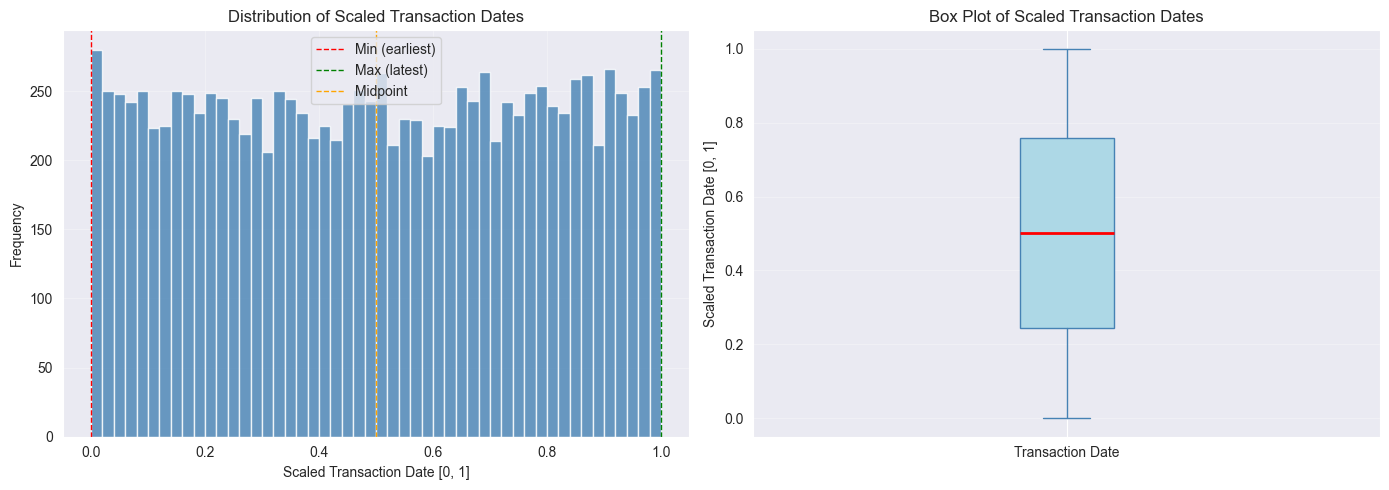


Scaled Transaction Date Summary:
  Mean:   0.5014
  Median: 0.5013
  Std:    0.2926
  Q1:     0.2435
  Q3:     0.7583


In [6]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Histogram of scaled dates
axes[0].hist(df[DATE_SCALED_COL], bins=50, color='steelblue', edgecolor='white', alpha=0.8)
axes[0].set_xlabel('Scaled Transaction Date [0, 1]')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Scaled Transaction Dates')
axes[0].axvline(0, color='red', linestyle='--', linewidth=1, label='Min (earliest)')
axes[0].axvline(1, color='green', linestyle='--', linewidth=1, label='Max (latest)')
axes[0].axvline(0.5, color='orange', linestyle='--', linewidth=1, label='Midpoint')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Box plot
axes[1].boxplot(df[DATE_SCALED_COL], vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', color='steelblue'),
                medianprops=dict(color='red', linewidth=2),
                whiskerprops=dict(color='steelblue'),
                capprops=dict(color='steelblue'))
axes[1].set_ylabel('Scaled Transaction Date [0, 1]')
axes[1].set_title('Box Plot of Scaled Transaction Dates')
axes[1].set_xticklabels(['Transaction Date'])
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nScaled Transaction Date Summary:")
print(f"  Mean:   {df[DATE_SCALED_COL].mean():.4f}")
print(f"  Median: {df[DATE_SCALED_COL].median():.4f}")
print(f"  Std:    {df[DATE_SCALED_COL].std():.4f}")
print(f"  Q1:     {df[DATE_SCALED_COL].quantile(0.25):.4f}")
print(f"  Q3:     {df[DATE_SCALED_COL].quantile(0.75):.4f}")

## Step 6: Save Output

Save the dataset with all three date columns: original, numeric, and scaled.

In [7]:
# Create output directory if it doesn't exist
OUTPUT_CSV.parent.mkdir(parents=True, exist_ok=True)

# Save to CSV
df.to_csv(OUTPUT_CSV, index=False)

print(f"✓ Dataset saved successfully!")
print(f"  Output file: {OUTPUT_CSV.resolve()}")
print(f"  Rows: {len(df)}")
print(f"  Columns: {len(df.columns)}")
print(f"\n  New columns added:")
print(f"    - {DATE_NUMERIC_COL}: Unix timestamp (seconds)")
print(f"    - {DATE_SCALED_COL}: Min-Max normalized [0, 1]")
print(f"\n  Column list:")
print(f"    {list(df.columns)}")

✓ Dataset saved successfully!
  Output file: /Users/luan/Study/WLU/Data Analysis/Deliverable_1/handle_rescale_data/output_data/transaction_date/data_rescaling_norm_transaction_date.csv
  Rows: 11971
  Columns: 13

  New columns added:
    - Transaction Date Numeric: Unix timestamp (seconds)
    - Transaction Date Scaled: Min-Max normalized [0, 1]

  Column list:
    ['Transaction ID', 'Customer ID', 'Category', 'Item', 'Price Per Unit', 'Quantity', 'Total Spent', 'Payment Method', 'Location', 'Transaction Date', 'Discount Applied', 'Transaction Date Numeric', 'Transaction Date Scaled']
